In [72]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms,  datasets
import os
from pathlib import Path
from torchinfo import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [4]:
data_path = Path("data")
image_path = data_path / "image_classification"

#data/image_classification

In [5]:
train_dir = "../data/image_classification/test"
test_dir =  "../data/image_classification/train"

train_dir, test_dir

('../data/image_classification/test', '../data/image_classification/train')

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform, target_transform=None)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform, target_transform=None)

In [7]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 150
     Root location: ../data/image_classification/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 450
     Root location: ../data/image_classification/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [8]:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8b31f83100>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8b31f76e20>)

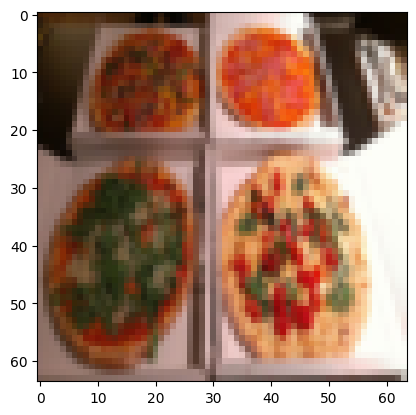

In [96]:
img, lable = next(iter(test_dataloader))
img.shape, lable.shape

random_idx = np.random.randint(0, 32)
single_img = img[random_idx]
plt.imshow(single_img.permute(1,2,0))

In [50]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,out_channels = hidden_units,
                  kernel_size = 2, stride = 1, padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 2, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.conv_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 2, stride = 1, padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 2, stride = 1, padding = 0 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units* 13*13, out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_1(x)
    #print(x.shape)
    x = self.conv_2(x)
    #print(x.shape)
    x = self.classifier(x)

    return x

In [66]:
torch.manual_seed(42)
model_vgg = TinyVGG(input_shape = 3, hidden_units = 64, output_shape = len(class_names))
model_vgg

TinyVGG(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10816, out_features=3, bias=True)
  )
)

In [54]:
summary(model_vgg, input_size=(32, 3, 64, 64), 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=16, 
        row_settings=("var_names",))

Layer (type (var_name))                  Input Shape      Output Shape     Param #          Trainable
TinyVGG (TinyVGG)                        [32, 3, 64, 64]  [32, 3]          --               True
├─Sequential (conv_1)                    [32, 3, 64, 64]  [32, 64, 31, 31] --               True
│    └─Conv2d (0)                        [32, 3, 64, 64]  [32, 64, 63, 63] 832              True
│    └─ReLU (1)                          [32, 64, 63, 63] [32, 64, 63, 63] --               --
│    └─Conv2d (2)                        [32, 64, 63, 63] [32, 64, 62, 62] 16,448           True
│    └─ReLU (3)                          [32, 64, 62, 62] [32, 64, 62, 62] --               --
│    └─MaxPool2d (4)                     [32, 64, 62, 62] [32, 64, 31, 31] --               --
├─Sequential (conv_2)                    [32, 64, 31, 31] [32, 64, 13, 13] --               True
│    └─Conv2d (0)                        [32, 64, 31, 31] [32, 64, 30, 30] 16,448           True
│    └─ReLU (1)                

In [55]:
img, label = next(iter(train_dataloader))

img_single, label_single = img[0].unsqueeze(dim=0), label[0]

model_vgg.eval()
with torch.inference_mode():
  out = model_vgg(img_single)

print(out)

tensor([[ 0.0065, -0.0216, -0.0587]])


In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)


In [68]:
model_vgg.train()

for epoch in range(10):
    train_acc, train_loss = 0.0, 0.0
    
    for i, (img, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        out = model_vgg(img)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        
        train_acc += (out.argmax(dim=1) == label).float().mean()
        train_loss += loss.item()
        
    train_acc /= len(train_dataloader)
    
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    

Epoch: 1, Train Loss: 5.5258, Train Acc: 0.4528
Epoch: 2, Train Loss: 5.2371, Train Acc: 0.4040
Epoch: 3, Train Loss: 4.5208, Train Acc: 0.6119
Epoch: 4, Train Loss: 4.3921, Train Acc: 0.6483
Epoch: 5, Train Loss: 4.0812, Train Acc: 0.6239
Epoch: 6, Train Loss: 3.7641, Train Acc: 0.7045
Epoch: 7, Train Loss: 3.5067, Train Acc: 0.7108
Epoch: 8, Train Loss: 3.3991, Train Acc: 0.6642
Epoch: 9, Train Loss: 3.3682, Train Acc: 0.7443
Epoch: 10, Train Loss: 3.2438, Train Acc: 0.7170


In [70]:
model_vgg.eval()

test_loss, test_acc = 0.0, 0.0
with torch.inference_mode():
    for i, (img, label) in enumerate(test_dataloader):
        out = model_vgg(img)
        loss = criterion(out, label)
        
        test_loss += loss.item()
        test_acc += (out.argmax(dim=1) == label).float().mean()
        
    test_acc /= len(test_dataloader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 16.4379, Test Acc: 0.3792


100%|██████████| 15/15 [00:01<00:00,  9.86it/s]
/var/folders/vq/zk2fmtnd52x9shn3q484yglm0000gn/T/ipykernel_21375/3295575883.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


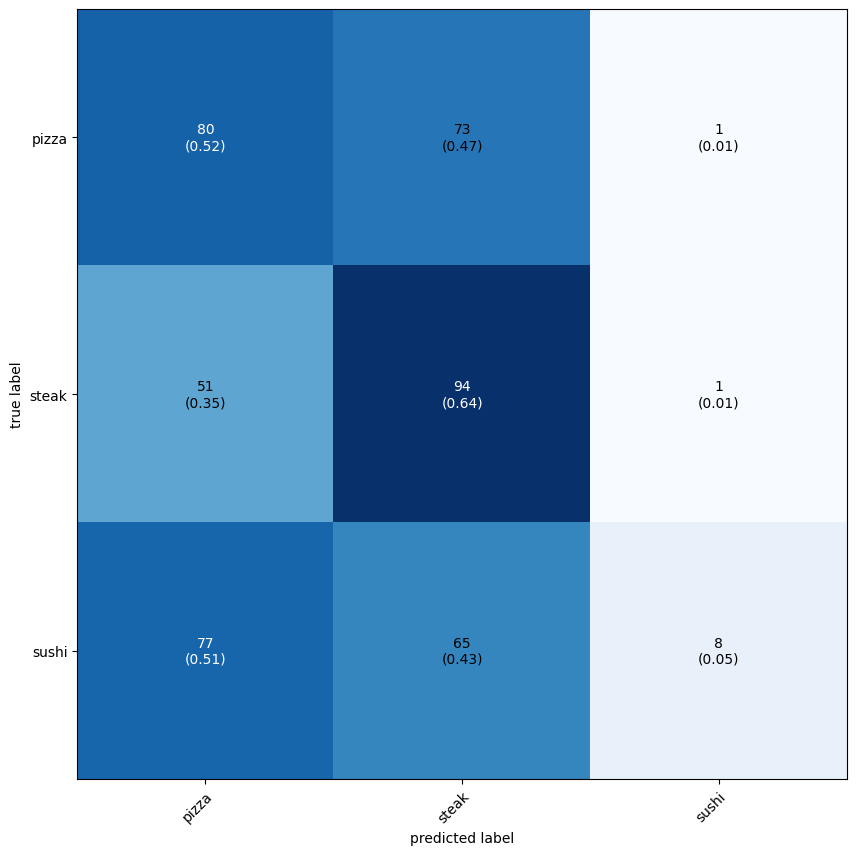

In [74]:
from tqdm import tqdm

y_preds = []

model_vgg.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        logits = model_vgg(X)
        pred = torch.argmax(logits, dim=1)
        
        y_preds.append(pred)
        
y_preds = torch.cat(y_preds, dim=0)

test_truth = torch.cat([y for _, y in test_dataloader], dim=0) 
confmat = ConfusionMatrix(num_classes=len(class_names), task = "multiclass")
confmat_tensor = confmat(y_preds, test_truth)

fig, ax = plot_confusion_matrix(confmat_tensor.numpy(), figsize=(10, 10), class_names=class_names, show_normed=True)
fig.show()
        

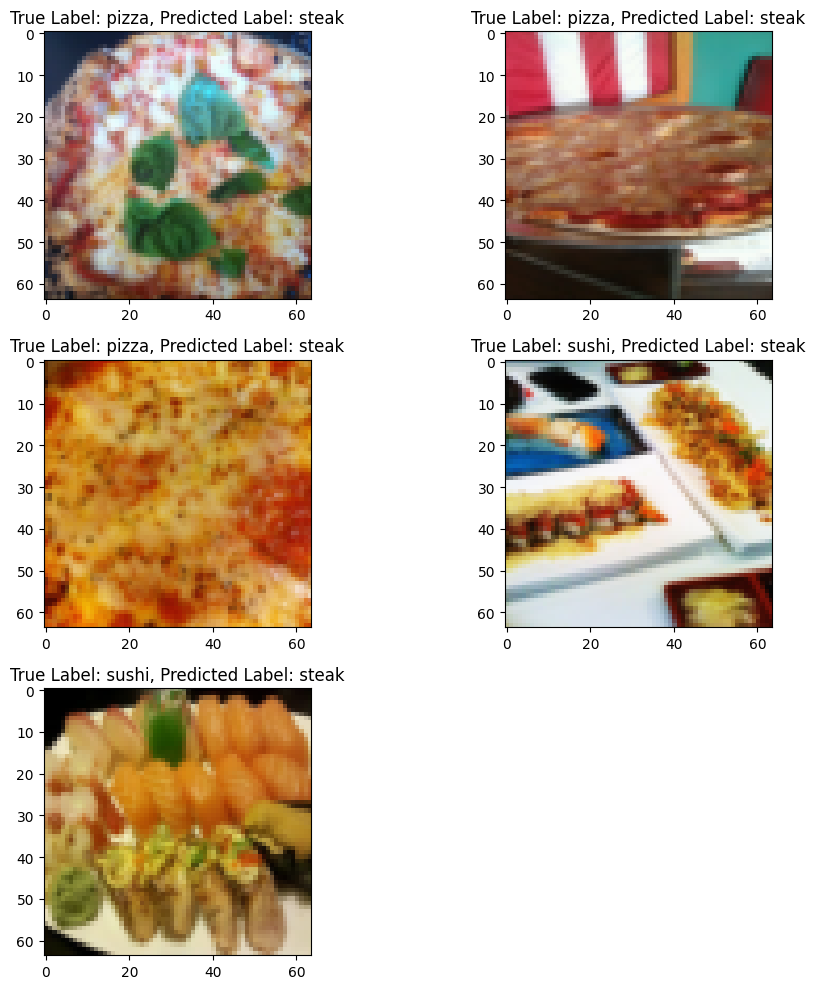

In [122]:
# Print Wrong Predictions
from matplotlib import pyplot as plt

wrong_preds = y_preds != test_truth
wrong_preds_idx = torch.where(wrong_preds)[0]

random_idx = np.random.choice(wrong_preds_idx, 5)
wrong_pred_idx_sample = wrong_preds_idx[:5]

plt.figure(figsize=(10, 10)) 
for idx, i in enumerate(random_idx):
    img, label = test_dataset[i]
    pred = y_preds[i]

    img = img.permute(1, 2, 0)
    img = img.numpy()


    #print(f"True Label: {class_names[label]}, Predicted Label: {class_names[pred], prediction_prob.max().item()}")
    plt.subplot(len(wrong_pred_idx_sample) // 2 + len(wrong_pred_idx_sample) % 2, 2, idx + 1)
    plt.title(f"True Label: {class_names[label]}, Predicted Label: {class_names[pred]}")
    plt.imshow(img)

plt.tight_layout()
plt.show()
